# Exact and noisy simulation with Qiskit Aer primitives



<details>
  <summary><b>Package versions</b></summary>

  The code on this page was developed using the following requirements.
  We recommend using these versions or newer.

  ```
  qiskit[all]~=2.1.1
  qiskit-aer~=0.17
  ```
</details>



[Exact simulation with Qiskit primitives](./simulate-with-qiskit-sdk-primitives) demonstrates how to use the reference primitives included with Qiskit to perform exact simulation of quantum circuits. Currently existing quantum processors suffer from errors, or noise, so the results of an exact simulation do not necessarily reflect the results you would expect when running circuits on real hardware. While the reference primitives in Qiskit do not support modeling noise, [Qiskit Aer](https://qiskit.org/ecosystem/aer/) includes implementations of the primitives that do support modeling noise. Qiskit Aer is a high-performance quantum circuit simulator that you can use in place of the reference primitives for better performance and more features. It is part of the [Qiskit Ecosystem](https://qiskit.github.io/ecosystem/). In this article, we demonstrate the use of Qiskit Aer primitives for exact and noisy simulation.

<Admonition type="note" title="Notes">
  *   `qiskit-aer` 0.14 or later is required.
  *   While Qiskit Aer primitives implement the primitive interfaces, they do not provide the same options as Qiskit Runtime primitives. Resilience level, for example, is not available with Qiskit Aer primitives.
</Admonition>

To explore exact and noisy simulation, create an example circuit on eight qubits:



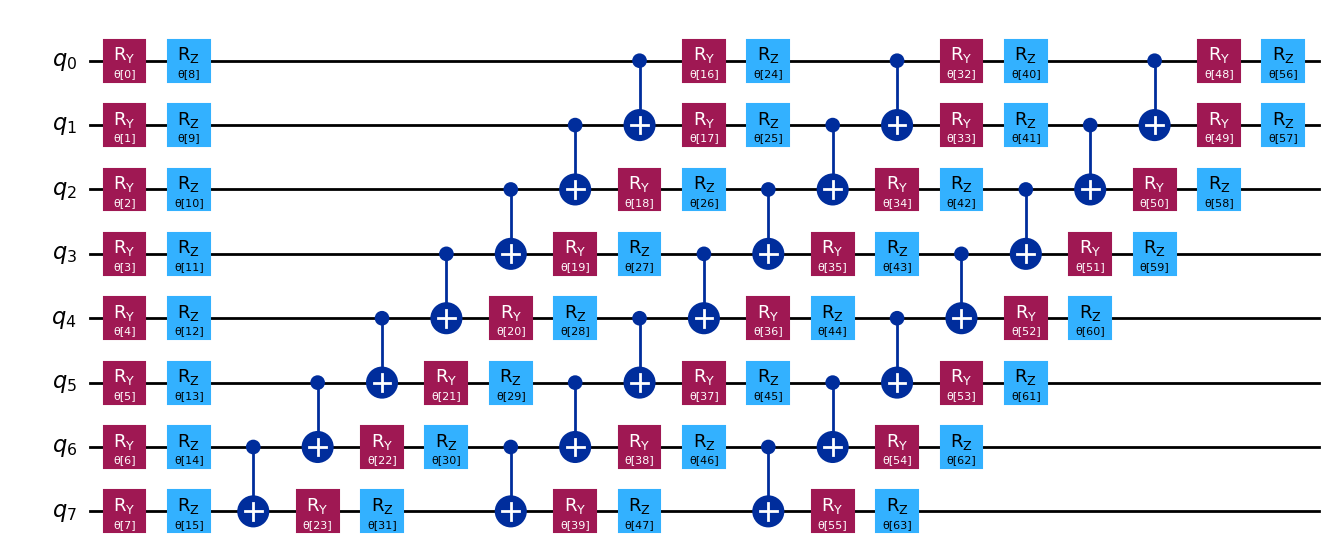

In [1]:
from qiskit.circuit.library import efficient_su2

n_qubits = 8
circuit = efficient_su2(n_qubits)
circuit.draw("mpl")

This circuit contains parameters to represent the rotation angles for $R_y$ and $R_z$ gates. When simulating this circuit, we need to specify explicit values for these parameters. In the next cell, we specify some values for these parameters and use the Estimator primitive from Qiskit Aer to compute the exact expectation value of the observable $ZZ \cdots Z$.



In [2]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator

observable = SparsePauliOp("Z" * n_qubits)
params = [0.1] * circuit.num_parameters

exact_estimator = Estimator()
# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(3, AerSimulator())
isa_circuit = pass_manager.run(circuit)
pub = (isa_circuit, observable, params)
job = exact_estimator.run([pub])
result = job.result()
pub_result = result[0]
exact_value = float(pub_result.data.evs)
exact_value

0.8870140234256602

Now, let's initialize a noise model that includes depolarizing error of 2% on every CX gate. In practice, the error arising from the two-qubit gates, which are CX gates here, are the dominant source of error when running a circuit. See [Build noise models](./build-noise-models) for an overview of constructing noise models in Qiskit Aer.

In the next cell, we construct an Estimator that incorporates this noise model and use it to compute the expectation value of the observable.



In [3]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

noisy_estimator = Estimator(
    options=dict(backend_options=dict(noise_model=noise_model))
)
job = noisy_estimator.run([pub])
result = job.result()
pub_result = result[0]
noisy_value = float(pub_result.data.evs)
noisy_value

0.7247404214143462

As you can see, the expectation value in the presence of the noise is quite far from the correct value. In practice, you can employ a variety of error mitigation techniques to counter the effects of the noise, but a discussion of these techniques is outside the scope of this article.

To get a very rough sense of how the noise affects the final result, consider our noise model, which adds a depolarizing error of 2% to each CX gate. Depolarizing error with probability $p$ is defined as a quantum channel $E$ that has the following action on a density matrix $\rho$:

$$
E(\rho) = (1 - p) \rho + p\frac{I}{2^n}
$$

where $n$ is the number of qubits, in this case, 2. That is, with probability $p$, the state is replaced with the completely mixed state, and the state is preserved with probability $1 - p$. After $m$ applications of the depolarizing channel, the probability of the state being preserved would be $(1 - p)^m$. Therefore, we expect the probability of retaining the correct state at the end of the simulation to go down exponentially with the number of CX gates in our circuit.

Let's count the number of CX gates in our circuit and compute $(1 - p)^m$. We call `count_ops` to get a dictionary that maps gate names to counts, and retrieve the entry for the CX gate.



In [4]:
cx_count = circuit.count_ops()["cx"]
(1 - cx_depolarizing_prob) ** cx_count

0.6542558123199923

This value, 65%, gives a rough estimate of the probability that our final state is correct. It is a conservative estimate because it does not take into account the initial state of the simulation.

The following code cell shows how to use the Sampler primitive from Qiskit Aer to sample from the noisy circuit. We need to add measurements to the circuit before running it with the Sampler primitive.



In [5]:
from qiskit_aer.primitives import SamplerV2 as Sampler

measured_circuit = circuit.copy()
measured_circuit.measure_all()

noisy_sampler = Sampler(
    options=dict(backend_options=dict(noise_model=noise_model))
)
# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(3, AerSimulator())
isa_circuit = pass_manager.run(measured_circuit)
pub = (isa_circuit, params, 100)
job = noisy_sampler.run([pub])
result = job.result()
pub_result = result[0]
pub_result.data.meas.get_counts()

{'00000000': 72,
 '10000000': 2,
 '10100011': 1,
 '11000000': 3,
 '00101000': 2,
 '01000000': 4,
 '01010000': 2,
 '00000110': 1,
 '00000011': 1,
 '10100000': 1,
 '00110000': 2,
 '00001000': 1,
 '00000101': 1,
 '00100000': 3,
 '00001010': 1,
 '10000100': 1,
 '00101010': 1,
 '00011000': 1}

## Next steps

<Admonition type="tip" title="Recommendations">
  *   To simulate small, simple circuits, see [Exact simulation with Qiskit primitives](./simulate-with-qiskit-sdk-primitives).
  *   Review the [Qiskit Aer](https://qiskit.org/ecosystem/aer/) documentation.
  *   Learn how to run on a quantum processor in the [Execute on hardware](./execute-on-hardware) step of the Qiskit patterns workflow.
</Admonition>



© IBM Corp., 2017-2025